In [1]:
from datetime import date
import pandas as pd
import numpy as np
import statistics

import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


from pandas_profiling import ProfileReport
from AutoRegression import AutoML
import pickle

In [2]:
df = pd.read_csv("data.csv")
df = df[['Date','2BRS_TIT_030A', '2BRS_TIT_030B','2BRS_PDIT_030','2BRS_FIT_030', '6BRS_PIT_015']]
df['Date']= pd.to_datetime(df['Date'])

salesprice = 10.5 #cent\kW
maintenancecost = 2000 #USD
#The main cost is the stopped production 
#to account for that, total $ value that could be earned will be calculated. 

#Some calculations
A1,B1,C1,dens = 1004.79,-0.0463,-0.0008,936.058
A,B,C,D,E,TC,LIQENT = 0.786889,-0.00187,4.163043,(-3.3*(10**(-7))),-0.0078,159,671.2794

df["T(F)"] = df["2BRS_TIT_030A"]*1.8 + 32 #convert from C to F
df["Flow(t/h)"] = df["2BRS_FIT_030"] * (A1 + B1*df["T(F)"] + C1*df["T(F)"]*df["T(F)"])/1000
df["Enthalpy_Entance (kj/kg)"] = (A + C*df["2BRS_TIT_030A"] + E*(df["2BRS_TIT_030A"]**2))/(1 + B*df["2BRS_TIT_030A"] + D*(df["2BRS_TIT_030A"]**2))
df["Enthalpy_Exit (kj/kg)"] = (A + C*df["2BRS_TIT_030B"] + E*(df["2BRS_TIT_030B"]**2))/(1 + B*df["2BRS_TIT_030B"] + D*(df["2BRS_TIT_030B"]**2))
df["MWE"] = 0.12*(df["Enthalpy_Entance (kj/kg)"] - df["Enthalpy_Exit (kj/kg)"]) * df["Flow(t/h)"] / 3600 #calculated, theoretical MWE
df["TempDiff"] = df["2BRS_TIT_030A"] - df["2BRS_TIT_030B"]

In [3]:
df= df.rename(columns={"2BRS_TIT_030A": "Entry temp (C)", 
                   "2BRS_TIT_030B": "Exit temp (C)",
                   "2BRS_PDIT_030": "Vap pres diff (bar)",
                   "2BRS_FIT_030": "Flowrate",
                   "6BRS_PIT_015": "Pump inj press",
                  })
df.head()

,Date,Entry temp (C),Exit temp (C),Vap pres diff (bar),Flowrate,Pump inj press,T(F),Flow(t/h),Enthalpy_Entance (kj/kg),Enthalpy_Exit (kj/kg),MWE,TempDiff
0,2018-04-25 01:00:00,105.72,99.46,1.5,1243.30,40.36,222.296,1187.308340,442.923394,416.509665,1.045375,6.26
1,2018-04-25 02:00:00,105.77,99.59,1.5,1253.11,40.36,222.386,1196.631207,443.134572,417.057688,1.040147,6.18
2,2018-04-25 03:00:00,105.70,99.48,1.5,1244.99,40.28,222.260,1188.940246,442.838923,416.593975,1.040123,6.22
3,2018-04-25 04:00:00,105.75,99.46,1.5,1245.53,40.27,222.350,1189.410873,443.050101,416.509665,1.052249,6.29
4,2018-04-25 05:00:00,105.82,99.48,1.5,1247.51,40.29,222.476,1191.238448,443.345754,416.593975,1.062258,6.34


In [4]:
def plotwithdates(df,start,end):
    #Sensor reads max 1.5 bar  
    #Pressure plot
    ax = df.plot.scatter(figsize = [12,5],x='Date',y='Vap pres diff (bar)',c='DarkBlue',label="Pressure")
    ax.set_ylabel("Pressure difference")
    ax.set_xlim([start,end])
    ax.grid()
    #Flowrate plot
    ax2 = df.plot.scatter(figsize = [12,5],x='Date',y='Flow(t/h)',c='green',label="Flowrate")
    ax2.set_xlim([start,end])
    ax2.grid()
    #MWE
    ax3 = df.plot.scatter(figsize = [12,5],x='Date',y='MWE',c='red',label="MWE")
    ax3.set_xlim([start,end])
    ax3.grid()
    #Temp diff
    ax4 = df.plot.scatter(figsize = [12,5],x='Date',y='TempDiff',c='blue',label="Temp Diff")
    ax4.set_xlim([start,end])
    ax4.set_ylim([0,20])
    ax4.grid()
    #Temp diff  
    ax5 = df.plot.scatter(figsize = [12,5],x='Date',y="Pump inj press",c='DarkBlue',label="Pressure")
    ax5.set_ylabel("Pump inj press")
    ax5.set_xlim([start,end])
    ax5.grid()

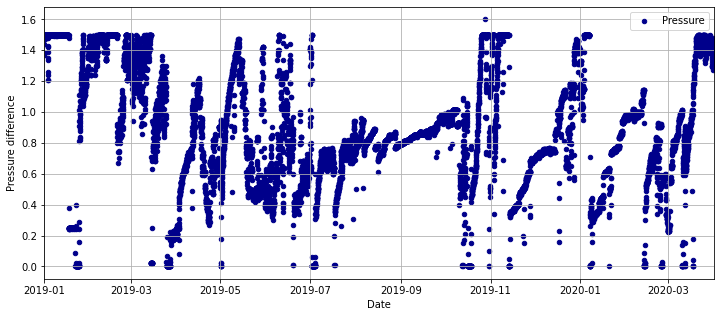

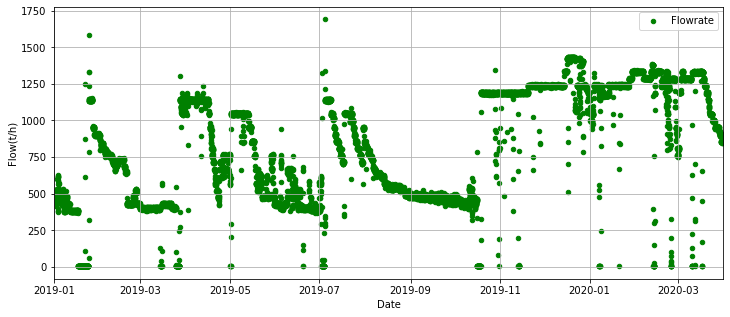

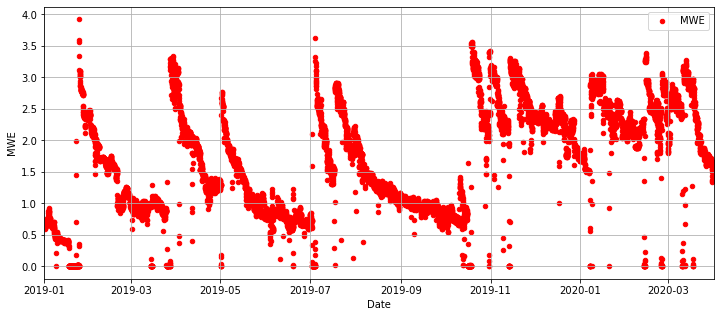

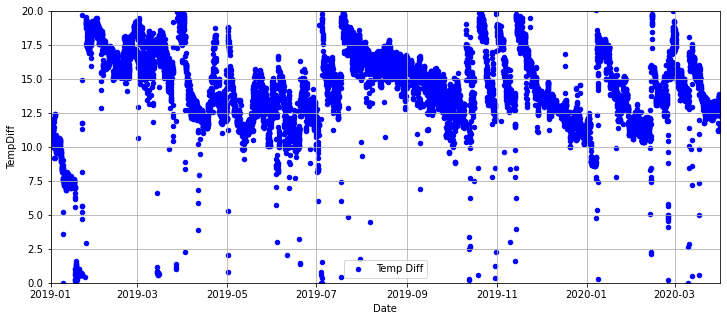

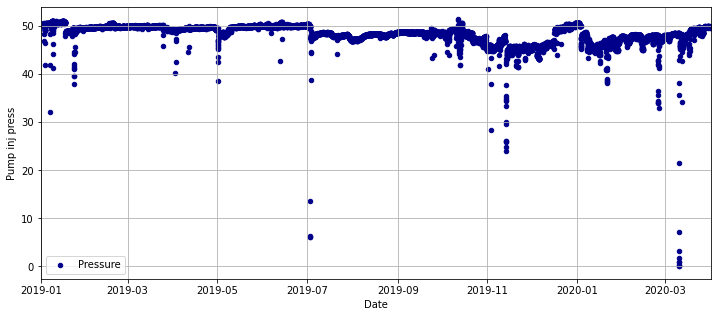

In [5]:
plotwithdates(df,start = date(2019,1,1),end = date(2020,4,1))

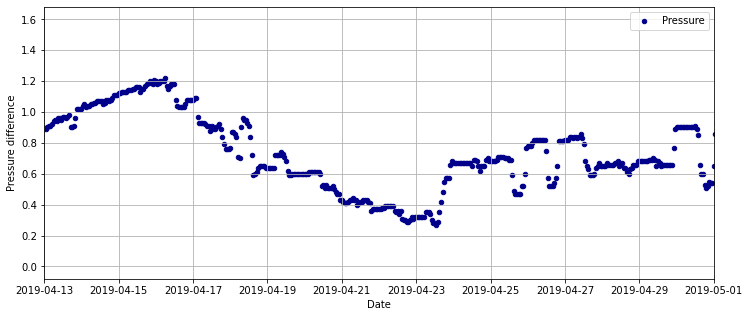

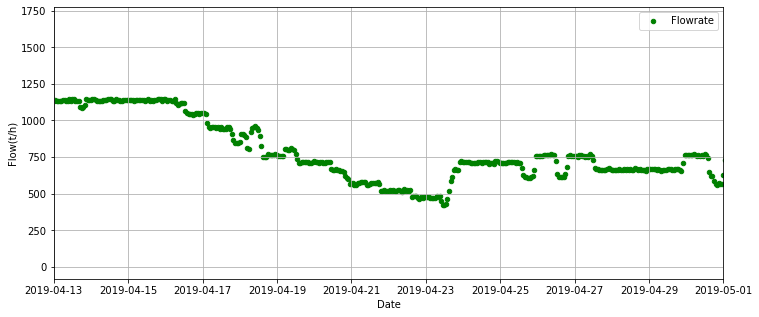

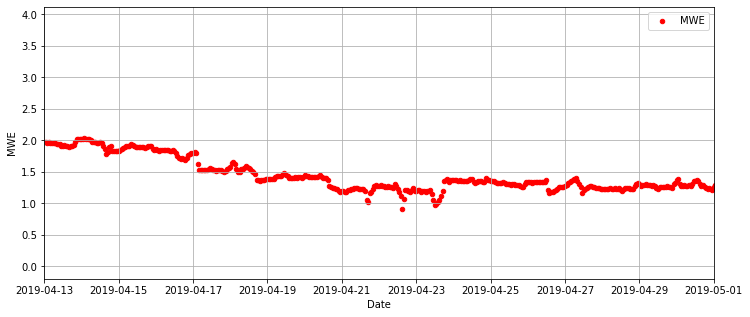

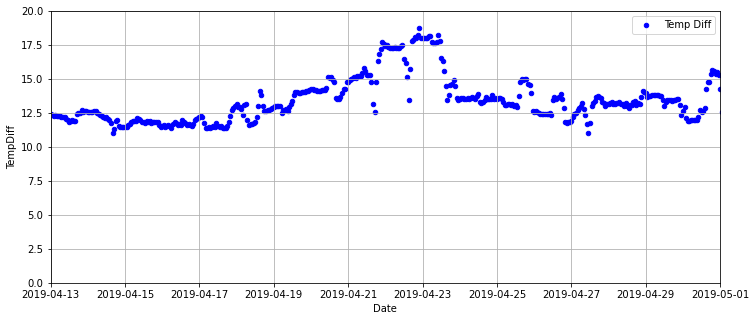

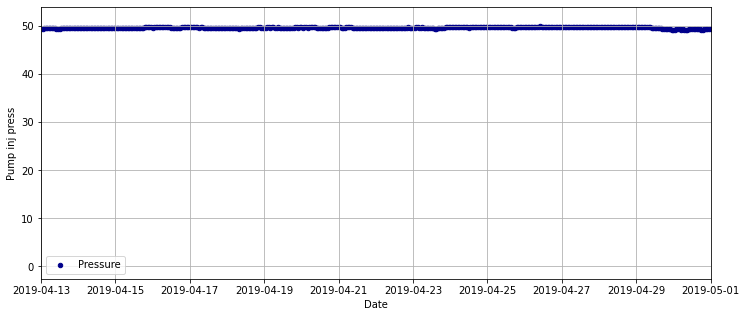

In [6]:
plotwithdates(df,start = date(2019,4,13),end = date(2019,5,1))

In [7]:
#For ML - only use the data with flow. 
df  = df[df["Flow(t/h)"] > 250]
df  = df[df["MWE"] > 0]
df  = df[df['Vap pres diff (bar)'] > 0.2]
df  = df[df['Vap pres diff (bar)'] < 1.4]

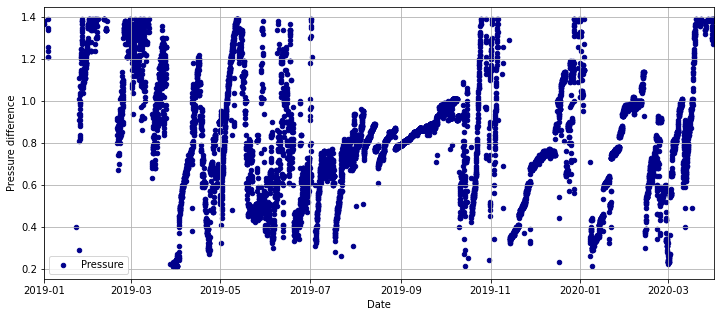

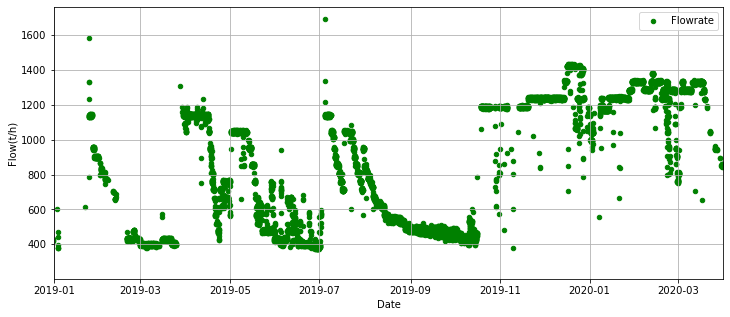

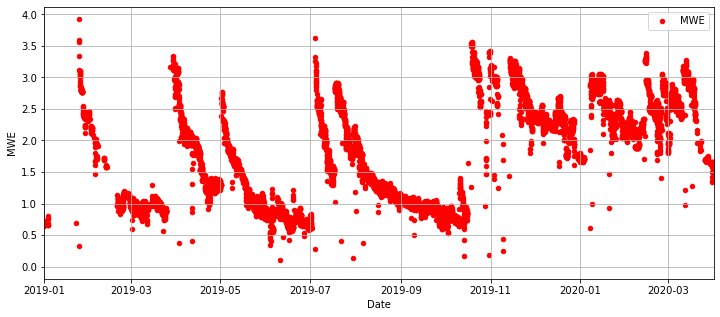

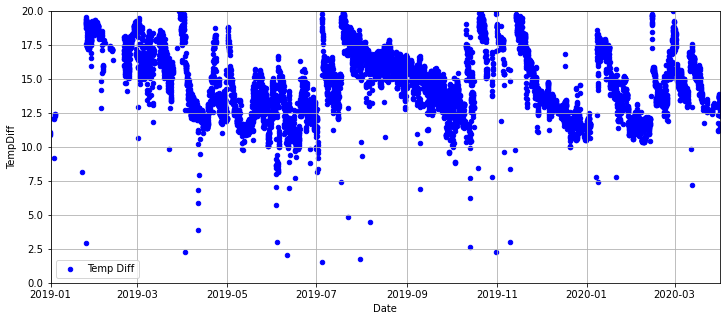

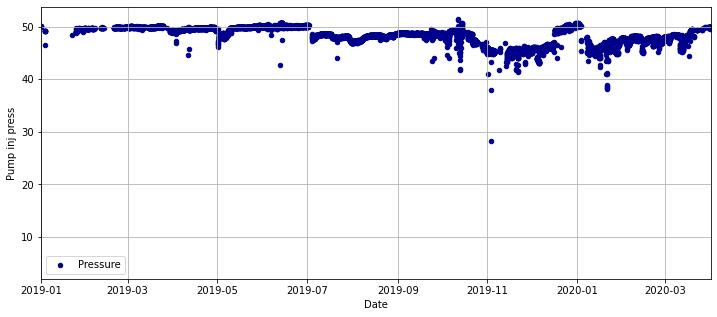

In [8]:
plotwithdates(df,start = date(2019,1,1),end = date(2020,4,1))

In [9]:
#Create the new hour feature for machine learning 
#the more we flow, the more pressures will increase

df['datediff'] = df['Date'].diff(1).astype('timedelta64[h]')
df = df.dropna()
datediff = df["datediff"].values
hour = np.zeros(len(datediff))

i = 0
while i< len(datediff):
    if i>0:
        if int(datediff[i]) == 1 or int(datediff[i]) == 0:
            hour[i] = hour[i-1] + 1
        elif int(datediff[i]) != 1 or int(datediff[i]) != 0:
            hour[i] = 0
    i = i+1
    
df['hour'] = hour

<ipython-input-9-94d651cc0501>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = hour


In [10]:
df = df.drop(columns= ["datediff","Flowrate","Entry temp (C)","Exit temp (C)","T(F)"])
df = df.reset_index(drop=True)
df.head()

,Date,Vap pres diff (bar),Pump inj press,Flow(t/h),Enthalpy_Entance (kj/kg),Enthalpy_Exit (kj/kg),MWE,TempDiff,hour
0,2018-04-30 14:00:00,0.76,40.69,808.436937,444.359475,430.722921,0.367476,3.23,0.0
1,2018-04-30 15:00:00,0.94,40.81,943.596502,444.359475,410.061403,1.078785,8.13,1.0
2,2018-04-30 16:00:00,0.97,40.36,952.355589,444.612918,412.674083,1.013904,7.57,2.0
3,2018-04-30 17:00:00,0.97,40.42,951.929162,444.148277,410.819876,1.057543,7.90,3.0
4,2018-04-30 18:00:00,0.98,40.42,950.510993,444.401715,410.482772,1.074678,8.04,4.0


In [11]:
profile = ProfileReport(df, explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

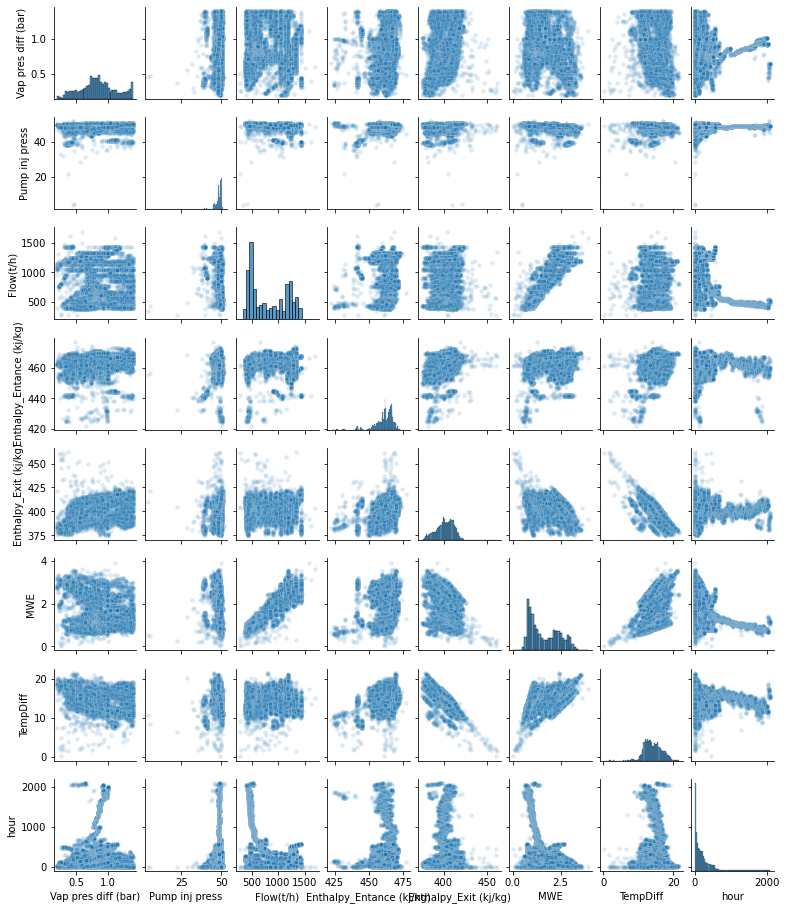

In [12]:
sns.pairplot(df.iloc[:,:], plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)

In [13]:
slice1 = list(range(1850,1934))
slice2 = list(range(3904,4148))
n = len(df)
slice_rest = list(range(0,1850)) + list(range(1934,3904)) + list(range(4148,n))
df_testing1 = df.iloc[slice1]
df_testing2 = df.iloc[slice2]
df = df.iloc[slice_rest]

In [14]:
dfML = df[['hour','TempDiff','Flow(t/h)','MWE']]
#dfML2 = df[['hour','TempDiff','Flow(t/h)','Pump inj press','Vap pres diff (bar)']]
dfML2 = df[['hour','Flow(t/h)','Vap pres diff (bar)']]

In [15]:
dfML.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hour,10605.0,330.490901,464.561412,0.00000,39.000000,158.000000,379.000000,2088.000000
TempDiff,10605.0,14.244953,2.474120,0.09000,12.470000,14.030000,15.940000,21.630000
Flow(t/h),10605.0,815.226151,350.756080,272.19818,476.555067,714.180784,1187.309627,1691.167392
MWE,10605.0,1.640127,0.778241,0.00359,0.938483,1.364126,2.327827,3.920225


In [16]:
dfML2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hour,10605.0,330.490901,464.561412,0.00000,39.000000,158.000000,379.000000,2088.000000
Flow(t/h),10605.0,815.226151,350.756080,272.19818,476.555067,714.180784,1187.309627,1691.167392
Vap pres diff (bar),10605.0,0.839851,0.274020,0.21000,0.670000,0.830000,1.000000,1.390000


Performing gridsearch for <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Grid Search Best Parameters for <class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'alpha': 0.0001, 'fit_intercept': True}
Performing gridsearch for <class 'sklearn.linear_model._ridge.Ridge'>
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Grid Search Best Parameters for <class 'sklearn.linear_model._ridge.Ridge'>
{'alpha': 0.01, 'fit_intercept': True}
Performing gridsearch for <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Grid Search Best Parameters for <class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 15}
Performing gridsearch for <class 'xgboost.sklearn.XGBRegressor'>
Fitting 3 folds for each of 576 candidates, totalli

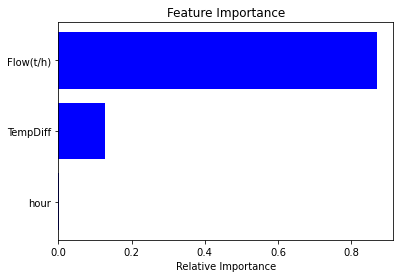

In [17]:
df_error,plt = AutoML(dfML,filename='MWEmodel',Perform_tuning = True)

In [18]:
df_error

,Explained variance score,Max error,Mean absolute error,Mean squared error,Median absolute error,r2 score,Mean absolute percentage error
Model,,,,,,,
MLPRegressor,1.000,0.043,0.005,0.000,0.004,1.000,0.004
RandomForestRegressor,1.000,0.250,0.007,0.000,0.003,1.000,0.006
SVR,0.998,0.092,0.031,0.001,0.031,0.998,0.025
Lasso,0.981,0.655,0.083,0.011,0.070,0.981,0.069
Ridge,0.981,0.656,0.083,0.011,0.070,0.981,0.069
LinearRegression,0.981,0.656,0.083,0.011,0.070,0.981,0.069
XGBRegressor,0.977,0.639,0.087,0.014,0.063,0.975,0.061


Performing gridsearch for <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Grid Search Best Parameters for <class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'alpha': 0.0001, 'fit_intercept': True}
Performing gridsearch for <class 'sklearn.linear_model._ridge.Ridge'>
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Grid Search Best Parameters for <class 'sklearn.linear_model._ridge.Ridge'>
{'alpha': 1, 'fit_intercept': True}
Performing gridsearch for <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Grid Search Best Parameters for <class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'bootstrap': True, 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 15}
Performing gridsearch for <class 'xgboost.sklearn.XGBRegressor'>
Fitting 3 folds for each of 576 candidates, totalling 

C:\Users\serca\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Grid Search Best Parameters for <class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
{'activation': 'relu', 'hidden_layer_sizes': 10, 'learning_rate': 'constant', 'solver': 'lbfgs'}


C:\Users\serca\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


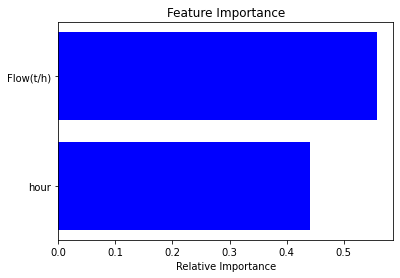

In [19]:
df_error2,plt2 = AutoML(dfML2,filename='Pres_model',Perform_tuning = True)

In [20]:
df_error2

,Explained variance score,Max error,Mean absolute error,Mean squared error,Median absolute error,r2 score,Mean absolute percentage error
Model,,,,,,,
RandomForestRegressor,0.504,1.051,0.113,0.038,0.045,0.504,0.171
SVR,0.483,1.084,0.126,0.040,0.079,0.480,0.184
MLPRegressor,0.302,0.974,0.170,0.054,0.122,0.302,0.259
XGBRegressor,0.205,0.858,0.193,0.062,0.155,0.201,0.291
LinearRegression,0.040,0.627,0.215,0.074,0.172,0.040,0.324
Ridge,0.040,0.627,0.215,0.074,0.172,0.040,0.324
Lasso,0.040,0.627,0.215,0.074,0.172,0.040,0.324


In [21]:
dfML_1 = df_testing1[['hour','TempDiff','Flow(t/h)','MWE']]
dfML_2 = df_testing2[['hour','TempDiff','Flow(t/h)','MWE']]

#dfML2_1 = df_testing1[['hour','TempDiff','Flow(t/h)','Pump inj press','Vap pres diff (bar)']]
#dfML2_2 = df_testing2[['hour','TempDiff','Flow(t/h)','Pump inj press','Vap pres diff (bar)']]

dfML2_1 = df_testing1[['hour','Flow(t/h)','Vap pres diff (bar)']]
dfML2_2 = df_testing2[['hour','Flow(t/h)','Vap pres diff (bar)']]

In [22]:
# load the model from disk
loaded_model1 = pickle.load(open('MWEmodelRF', 'rb'))
loaded_model2 = pickle.load(open('Pres_modelRF', 'rb'))

In [23]:
def predictions(dataframe,model):
    n = len(dataframe.columns)
    X = dataframe.iloc[:,0:n-1].to_numpy() 
    y = dataframe.iloc[:,n-1].to_numpy()
    y_predicted = model.predict(X)
    return y, y_predicted

In [24]:
y1, y_predicted1 = predictions(dfML_1,loaded_model1)

In [25]:
y2, y_predicted2 = predictions(dfML_2,loaded_model1)

In [26]:
y2_1, y_predicted2_1 = predictions(dfML2_1,loaded_model2)

In [27]:
y2_2, y_predicted2_2 = predictions(dfML2_2,loaded_model2)

In [28]:
def visualize_predictions(y_test,y_predicted):

    plt.figure(figsize=(10,10))
    plt.scatter(y_test, y_predicted, c='crimson')

    p1 = max(max(y_predicted), max(y_test))
    p2 = min(min(y_predicted), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    return plt

In [29]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

error_metrics = (
    explained_variance_score,
    max_error,
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    r2_score,
    mean_absolute_percentage_error        
)

errors = (
    'Explained variance score',
    'Max error',
    'Mean  absolute error',
    'Mean squared error',
    'Median absolute error',
    'r2 score',
    'Mean absolute percentage error'        
)

def validationerrors(y_test, y_predicted,error_metrics):
    calculations = []
    for metric in error_metrics:
        calc = metric(y_test, y_predicted)
        calculations.append(calc)
        df_error = pd.DataFrame(data=calculations)
        df_error = df_error.T
    return df_error

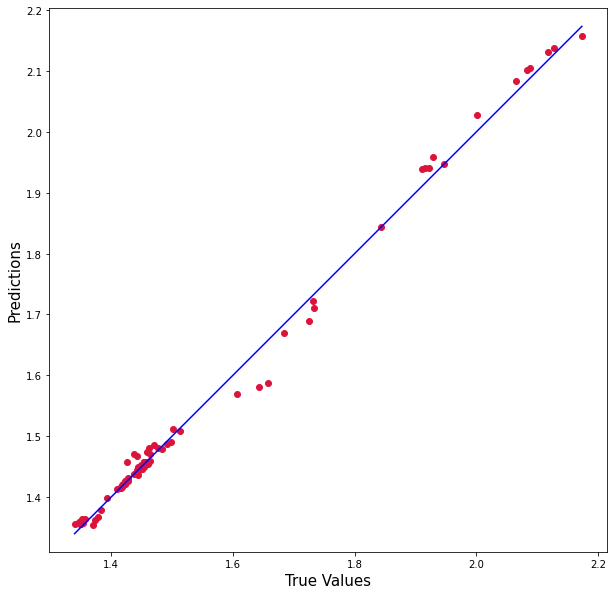

,Explained variance score,Max error,Mean absolute error,Mean squared error,Median absolute error,r2 score,Mean absolute percentage error
0,0.994392,0.0704,0.010281,0.00027,0.004808,0.99437,0.006374


In [30]:
visualize_predictions(y1, y_predicted1)
df1 = validationerrors(y1, y_predicted1,error_metrics)
df1.columns=errors
df1

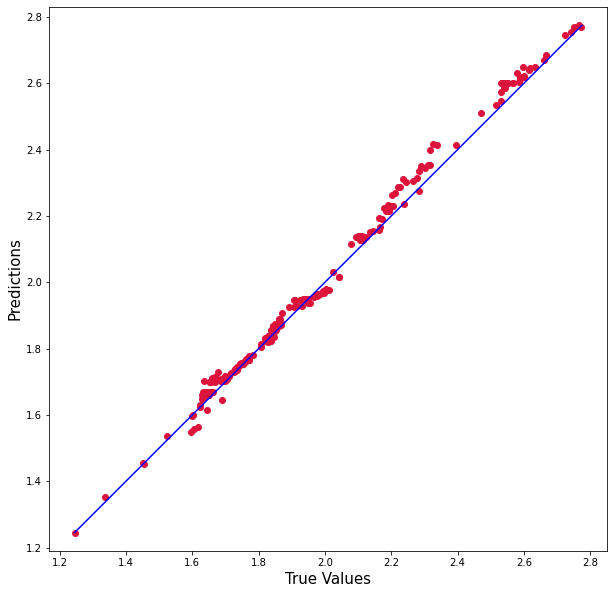

,Explained variance score,Max error,Mean absolute error,Mean squared error,Median absolute error,r2 score,Mean absolute percentage error
0,0.994283,0.090032,0.022342,0.000827,0.017997,0.991632,0.011192


In [31]:
visualize_predictions(y2, y_predicted2)
df2 = validationerrors(y2, y_predicted2,error_metrics)
df2.columns=errors
df2

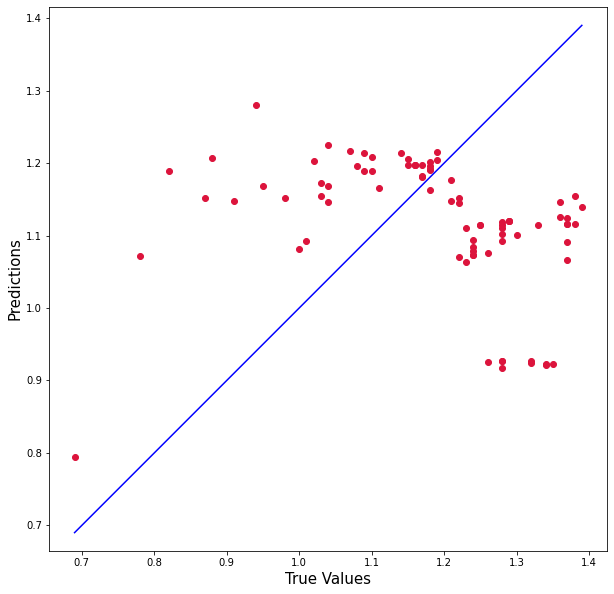

,Explained variance score,Max error,Mean absolute error,Mean squared error,Median absolute error,r2 score,Mean absolute percentage error
0,-0.686139,0.427416,0.169848,0.04161,0.163802,-0.854421,0.145223


In [32]:
visualize_predictions(y2_1, y_predicted2_1)
df2_1 = validationerrors(y2_1, y_predicted2_1,error_metrics)
df2_1.columns=errors
df2_1

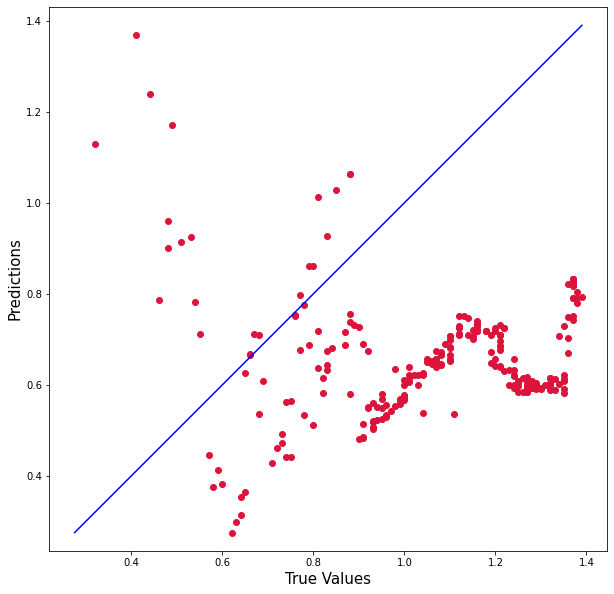

,Explained variance score,Max error,Mean absolute error,Mean squared error,Median absolute error,r2 score,Mean absolute percentage error
0,-0.364481,0.959067,0.437818,0.22811,0.426903,-2.800767,0.42486


In [33]:
visualize_predictions(y2_2, y_predicted2_2)
df2_2 = validationerrors(y2_2, y_predicted2_2,error_metrics)
df2_2.columns=errors
df2_2

In [34]:
def plotwithhour(df):
    #Flowrate plot
    ax2 = df.plot.scatter(figsize = [12,5],x='hour',y='Flow(t/h)',c='green',label="Flowrate")
    ax2.grid()
    try:
        #MWE
        ax3 = df.plot.scatter(figsize = [12,5],x='hour',y='MWE',c='red',label="MWE")
    except:
        ax3 = df.plot.scatter(figsize = [12,5],x='hour',y='Vap pres diff (bar)',c='red',label="MWE")
        ax3.grid()   
    #Temp diff
    ax4 = df.plot.scatter(figsize = [12,5],x='hour',y='TempDiff',c='blue',label="Temp Diff")
    ax4.set_ylim([0,20])
    ax4.grid()

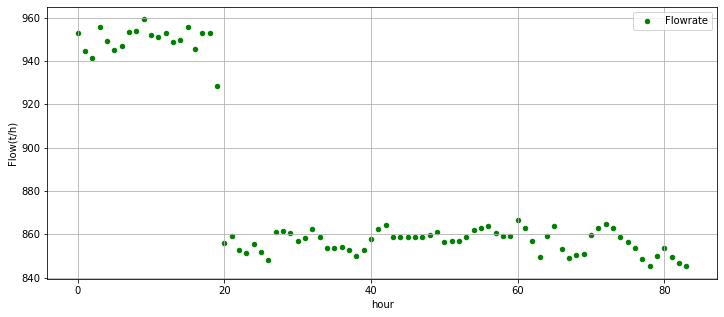

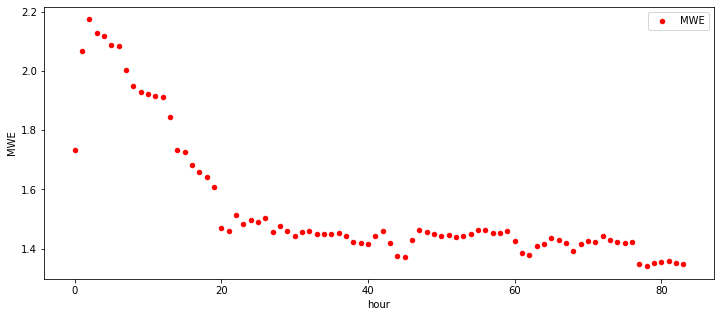

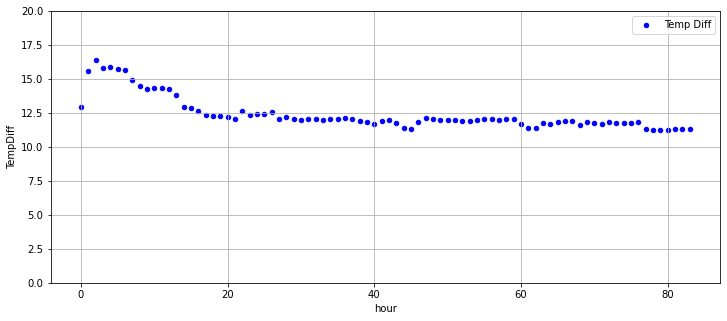

In [35]:
plotwithhour(dfML_1)

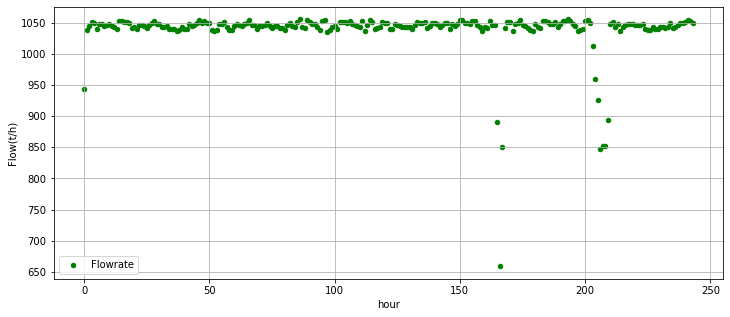

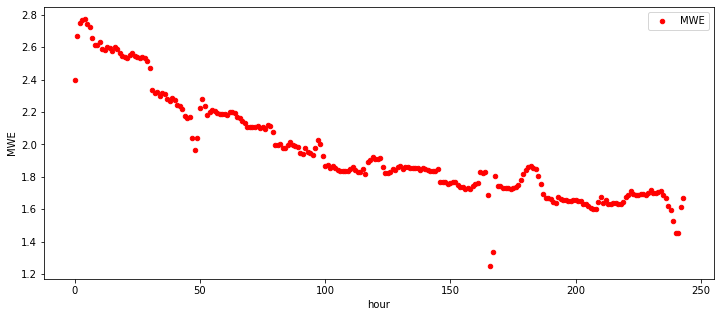

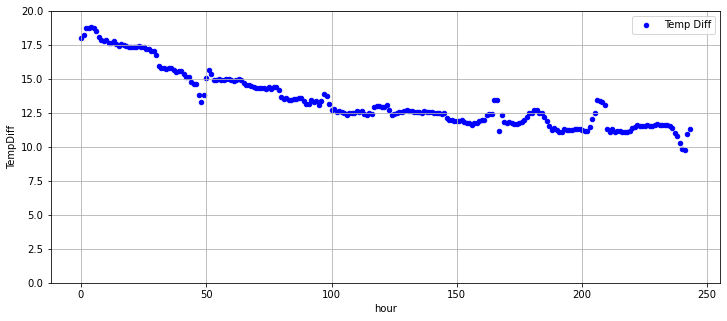

In [36]:
plotwithhour(dfML_2)

KeyError: 'TempDiff'

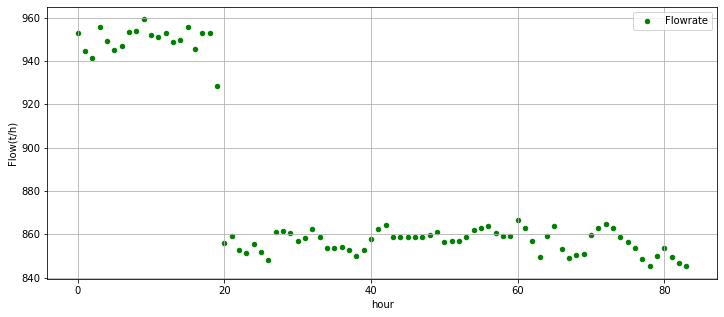

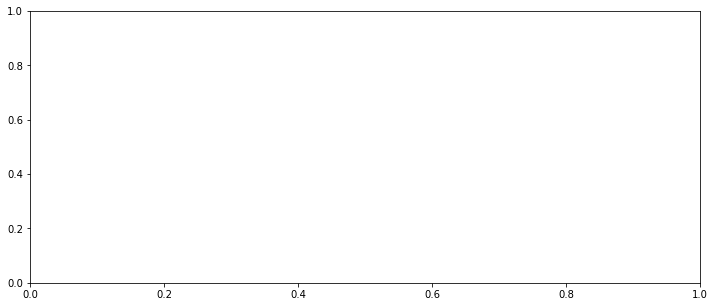

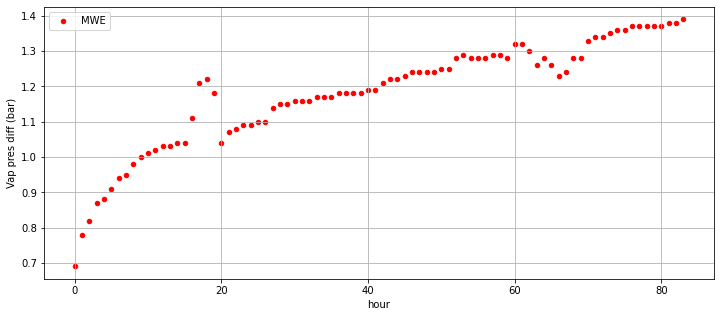

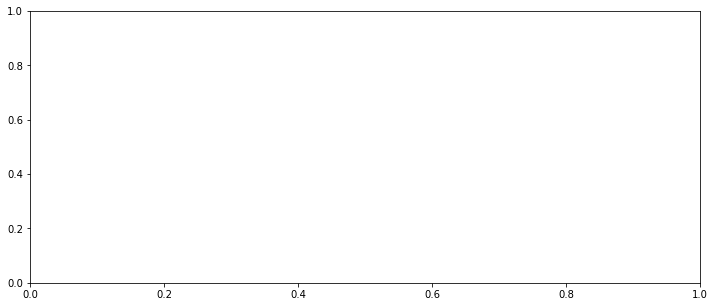

In [37]:
plotwithhour(dfML2_1)

In [ ]:
plotwithhour(dfML2_2)

In [ ]:
#Simulations with new data

In [ ]:
dfML2_1